In [ ]:
import matplotlib.pyplot as plt
import dataset
import importlib
importlib.reload(dataset)
import matplotlib.pyplot as plt


# assuming SineMixDataset is already defined/imported
ds = dataset.SineMixDataset(
    n=10, T=100, duration=1.0,
    freqs=[1,5],
    n_components=2,s
    noise_std=0.11,
    n_obs=40,
    # n_obs_range=(4,10),
    seed=42
)



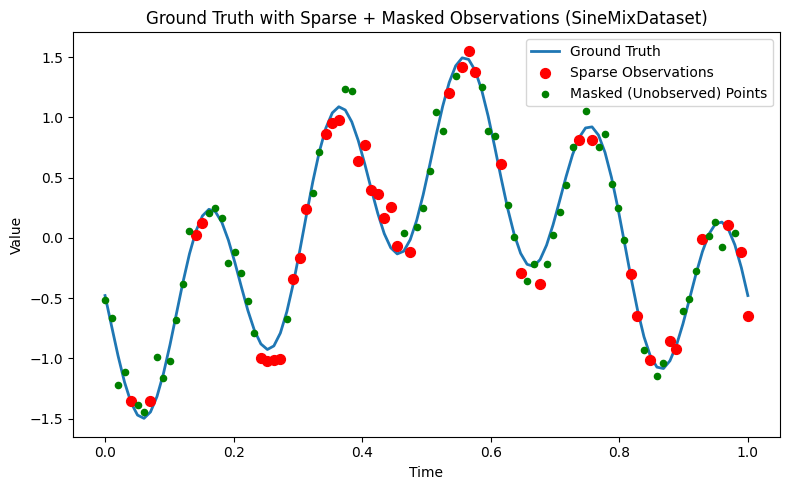

In [ ]:
# Pick a sample (similar to your index=1000 example)
index =20
sample = ds[index]

# unpack (use feature 0 since it's univariate)
dense_positions = sample["positions"].squeeze(0).numpy()          # (T,)
ground_truth    = sample["ground_truth"][:, 0].numpy()            # (T,)
values          = sample["values"][:, 0].numpy()                  # (T,)
observed_mask   = ~sample["mask"].numpy().astype(bool)            # True = observed
masked_mask     = sample["mask"].numpy().astype(bool)                                # True = unobserved (masked)

# build sparse positions/values from the observed mask (red)
sparse_positions = dense_positions[observed_mask]
sparse_values    = values[observed_mask]

plt.figure(figsize=(8, 5))
plt.plot(dense_positions, ground_truth, label="Ground Truth", linewidth=2)
plt.scatter(sparse_positions, sparse_values, color='red', label="Sparse Observations",
            s=50, zorder=5)
plt.scatter(dense_positions[masked_mask], values[masked_mask], color='green',
            label="Masked (Unobserved) Points", s=20, zorder=5)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Ground Truth with Sparse + Masked Observations (SineMixDataset)")
plt.legend()
plt.tight_layout()
plt.show()

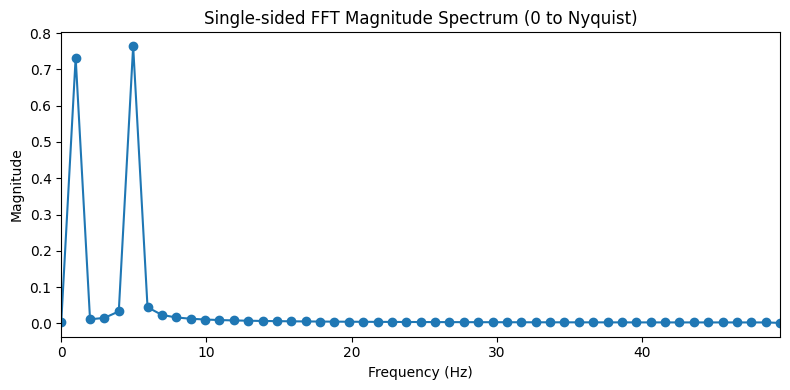

In [27]:
import numpy as np

# sample spacing and length
dt = dense_positions[1] - dense_positions[0]
N = ground_truth.size

# use rfft/rfftfreq to get only non-negative frequencies up to Nyquist
gt_fft = np.fft.rfft(ground_truth)
gt_freqs = np.fft.rfftfreq(N, d=dt)

# compute single-sided magnitude spectrum and normalize (optional amplitude scaling)
magnitude = np.abs(gt_fft) / N
if N % 2 == 0:
    # even N: Nyquist bin exists and should not be doubled
    magnitude[1:-1] *= 2
else:
    magnitude[1:] *= 2

plt.figure(figsize=(8, 4))
plt.plot(gt_freqs, magnitude, marker='o')
plt.title("Single-sided FFT Magnitude Spectrum (0 to Nyquist)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, gt_freqs[-1])  # ensure we only plot up to Nyquist
plt.tight_layout()
plt.show()


# Evaluations

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

from romae.model import (RoMAEForPreTraining, RoMAEForPreTrainingConfig)
from romae.utils import get_encoder_size, load_from_checkpoint

# import your dataset class
from dataset import SineMixDataset

def make_loaders_for_sparsity(n, T, duration, freqs, n_components, noise_std, seed, n_obs_values, batch_size=1):
    """Create a dict {n_obs: DataLoader} with fixed n_obs per split."""
    loaders = {}
    datasets = {}
    for n_obs in n_obs_values:
        ds = SineMixDataset(
            n=n, T=T, duration=duration,
            freqs=freqs, n_components=n_components,
            noise_std=noise_std,
            n_obs=n_obs,              # fixed sparsity per dataset
            seed=seed
        )
        datasets[n_obs] = ds
        loaders[n_obs] = DataLoader(ds, batch_size=batch_size, shuffle=False)
    return datasets, loaders

def evaluate_sinemix_mse(checkpoint_path, n=400, T=100, duration=1.0,
                         freqs=(1,5,20,35,45), n_components=3, noise_std=0.1,
                         seed=42, n_obs_values=(5,10,20)):
    # model
    _ = get_encoder_size("RoMAE-tiny")  # if you need this side-effect; kept for parity
    model = load_from_checkpoint(checkpoint_path, RoMAEForPreTraining, RoMAEForPreTrainingConfig)
    model.set_loss_fn(nn.MSELoss(reduction='mean'))
    model.eval()
    model.cuda() if torch.cuda.is_available() else None

    # data
    datasets, loaders = make_loaders_for_sparsity(
        n=n, T=T, duration=duration,
        freqs=freqs, n_components=n_components,
        noise_std=noise_std, seed=seed,
        n_obs_values=n_obs_values, batch_size=1
    )

    results = {k: {"loss": 0.0, "predictions": []} for k in n_obs_values}

    with torch.no_grad():
        for n_obs in n_obs_values:
            for batch in loaders[n_obs]:
                # move to device
                device = next(model.parameters()).device
                batch = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.items()}

                # forward
                pred, ll = model(**batch)  # pred shape depends on model; commonly (B,T,C,?,?)
                results[n_obs]["loss"] += ll.item()
                results[n_obs]["predictions"].append(pred.detach().cpu())

    # aggregate
    MSE = {k: results[k]["loss"] / len(datasets[k]) for k in n_obs_values}
    predictions = {k: results[k]["predictions"] for k in n_obs_values}
    return datasets, predictions, MSE

import matplotlib.pyplot as plt
import numpy as np

def _to_cpu_np(x):
    if torch.is_tensor(x): x = x.detach().cpu().numpy()
    return np.asarray(x)

def _to_np(x):
    import numpy as np, torch
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return np.asarray(x)

def _squeeze_gt(x):  # handles (T,1,1,1) or (T,1) → (T,)
    import numpy as np
    x = _to_np(x)
    return x.reshape(x.shape[0], -1)[:, 0]

def plot_panel_sinemix(datasets, predictions, n_obs_values=(5,10,20), sample_index=2, title_suffix=""):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, axes = plt.subplots(1, len(n_obs_values), figsize=(18, 5), sharey=True)
    if len(n_obs_values) == 1:
        axes = [axes]

    for ax, n_obs in zip(axes, n_obs_values):
        sample = datasets[n_obs][sample_index]

        # unpack
        t          = _to_np(sample["positions"]).squeeze(0)                    # (T,)
        values     = _squeeze_gt(sample["values"])                              # (T,)
        x_clean    = _squeeze_gt(sample["ground_truth"])                        # (T,)

        # mask semantics: mask=True means observed
        mask_obs   = _to_np(sample["mask"]).astype(bool).reshape(-1)            # (T,)
        mask_miss  = (mask_obs)                                                # (T,)

        # sparse obs from noisy values
        sparse_positions = t[~mask_obs]
        sparse_values    = values[~mask_obs]

        # pull prediction tensor for this sample
        pred_tensor = predictions[n_obs][sample_index]   # list element from evaluation
        pred = _to_np(pred_tensor).squeeze()

        # make a 1-D series
        pred_flat = pred.reshape(-1)
        T = t.shape[0]
        n_miss = int(mask_miss.sum())

        # choose alignment
        if pred_flat.size == n_miss:
            # model predicted only missing points, in time order
            t_pred = t[mask_miss]
            y_pred = pred_flat
        elif pred_flat.size == T:
            # model predicted full trajectory
            t_pred = t[mask_miss]
            y_pred = pred_flat[mask_miss]
        else:
            # unexpected shape; print and skip plotting predictions
            print(f"[warn] unexpected pred size {pred_flat.size}; T={T}, n_miss={n_miss}")
            t_pred, y_pred = None, None

        # plot
        ax.plot(t, x_clean, label="Ground Truth", linewidth=2, color="tab:blue")
        ax.scatter(sparse_positions, sparse_values, color='red',
                   label="Sparse Observations", s=50, zorder=5)
        ax.scatter(t[mask_miss], values[mask_miss], color='green',
                   label="Masked (Unobserved) Points", s=18, zorder=5)

        if y_pred is not None:
            ax.scatter(t_pred, y_pred, color='orange',
                    label="Predicted (masked region)", linewidth=2)
            ax.plot(t_pred, y_pred, color='orange', linewidth=2)
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.set_title(f"n_obs = {n_obs}{title_suffix}")
        ax.legend(loc="best")

    plt.tight_layout()
    plt.show()

import numpy as np
import torch
import matplotlib.pyplot as plt

def _to_np(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return np.asarray(x)

def _single_sided_mag(y, dt):
    """
    Single-sided magnitude spectrum with standard amplitude scaling:
    - rfft magnitudes divided by N
    - double non-DC and non-Nyquist bins (if N even)
    """
    y = np.asarray(y)
    N = y.size
    Y = np.fft.rfft(y)
    freqs = np.fft.rfftfreq(N, d=dt)
    mag = np.abs(Y) / N
    if N % 2 == 0:
        # even N: Nyquist bin exists and should not be doubled
        if N > 2:
            mag[1:-1] *= 2.0
    else:
        if N > 1:
            mag[1:] *= 2.0
    return freqs, mag

def fft_compare_sample(sample, pred_tensor, title_suffix=""):
    """
    Compare FFT of ground truth vs model prediction for a single sample.
    - sample: one item from SineMixDataset
    - pred_tensor: the prediction returned by your model for that sample
                   (either full (T,1[,1,1]) or only-missing (n_miss,))
    """
    # --- unpack sample ---
    t         = _to_np(sample["positions"]).squeeze(0)              # (T,)
    x_clean   = _to_np(sample["ground_truth"])                       # (T,1,1,1) or (T,1)
    x_clean   = x_clean.reshape(x_clean.shape[0], -1)[:, 0]          # (T,)
    x_noisy   = _to_np(sample["values"]).reshape(len(t), -1)[:, 0]   # (T,) (used only if we need to fill observed points)
    mask_obs  = _to_np(sample["mask"]).astype(bool).reshape(-1)      # (T,)  True = observed
    mask_miss = mask_obs                                            # (T,)  True = missing
    T         = len(t)
    dt        = t[1] - t[0]

    # --- normalize pred to 1D numpy ---
    pred = _to_np(pred_tensor).squeeze()

    # --- reconstruct a full-length prediction on the same grid ---
    if pred.size == T:
        # full trajectory predicted
        y_hat_full = pred
    elif pred.size == int(mask_miss.sum()):
        # only missing positions predicted — fill them
        y_hat_full = x_noisy.copy()  # keep observed points as the actually observed (noisy) values
        # assume predictions are in time order for the missing indices:
        y_hat_full[mask_miss] = pred
    else:
        raise ValueError(f"Unexpected prediction size {pred.size}; T={T}, missing={mask_miss.sum()}.")

    # --- FFTs (single-sided) ---
    f_gt, mag_gt   = _single_sided_mag(x_clean, dt)
    f_ph, mag_pred = _single_sided_mag(y_hat_full, dt)

    # --- time-domain (optional small plot) + frequency-domain comparison ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Time domain: show GT and reconstruction
    axes[0].plot(t, x_clean, label="Ground Truth", lw=2)
    axes[0].plot(t, y_hat_full, label="Prediction (full)", alpha=0.8)
    # For context, show sparse observed points (red)
    axes[0].scatter(t[mask_obs], x_noisy[mask_obs], s=18, color="red", label="Observed pts", zorder=5)
    axes[0].set_title(f"Time domain {title_suffix}")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Value")
    axes[0].legend()

    # Frequency domain: single-sided spectra
    axes[1].plot(f_gt, mag_gt, marker='o', label="GT spectrum")
    axes[1].plot(f_ph, mag_pred, marker='x', label="Pred spectrum")
    axes[1].set_title("Single-sided FFT magnitude (0..Nyquist)")
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_ylabel("Magnitude")
    axes[1].set_xlim(0, f_gt[-1])
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:

datasets, preds, MSEs = evaluate_sinemix_mse(
    checkpoint_path="../checkpoints/checkpoint-9550",
    n=400, T=100, duration=1.0,
    freqs=(1,5),
    n_components=2,
    noise_std=0.1,
    seed=42,
    n_obs_values=(40,)   # note the comma
)



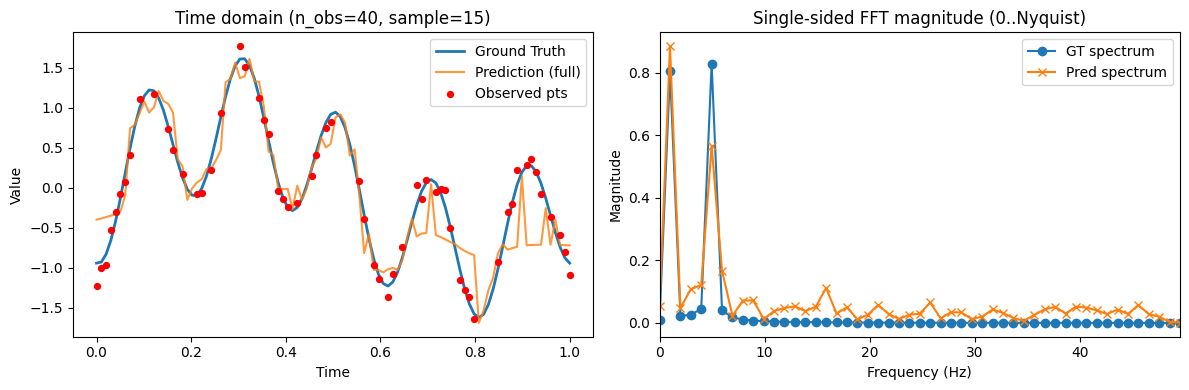

In [9]:
# pick a sparsity regime and sample index
n_obs = 40  # or 5, 10, 20 ...
sample_idx = 15

sample = datasets[n_obs][sample_idx]
pred_tensor = preds[n_obs][sample_idx]  # a tensor from evaluation

fft_compare_sample(sample, pred_tensor, title_suffix=f"(n_obs={n_obs}, sample={sample_idx})")